## Titanic Survival Challenge (Kaggle): A binary classification Problem

### Used scikitlearn and fastai libraries for this task. 

In [1]:
%load_ext autoreload
%autoreload 2

In [140]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plot.rcParams.update(params)

## Load the train & test data

In [141]:
PATH = "./Kaggle/Titanic/data/"
train_raw=pd.read_csv(f'{PATH}train.csv',low_memory=False)
test_raw=pd.read_csv(f'{PATH}test.csv',low_memory=False)

In [5]:
#check the size of the train and test data

train_raw.shape, test_raw.shape

((891, 12), (418, 11))

In [6]:
#check if the data loaded properly

train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Explore the data

In [117]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.616162
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


The count variable shows that 177 values are missing in the Age column. One solution is to fill in the null values with the median age. We could also impute with the mean age but the median is more robust to outlier.

In [100]:
data = train_raw
data['Died']= 1 - data['Survived']

Visualize the survival based on the gender.

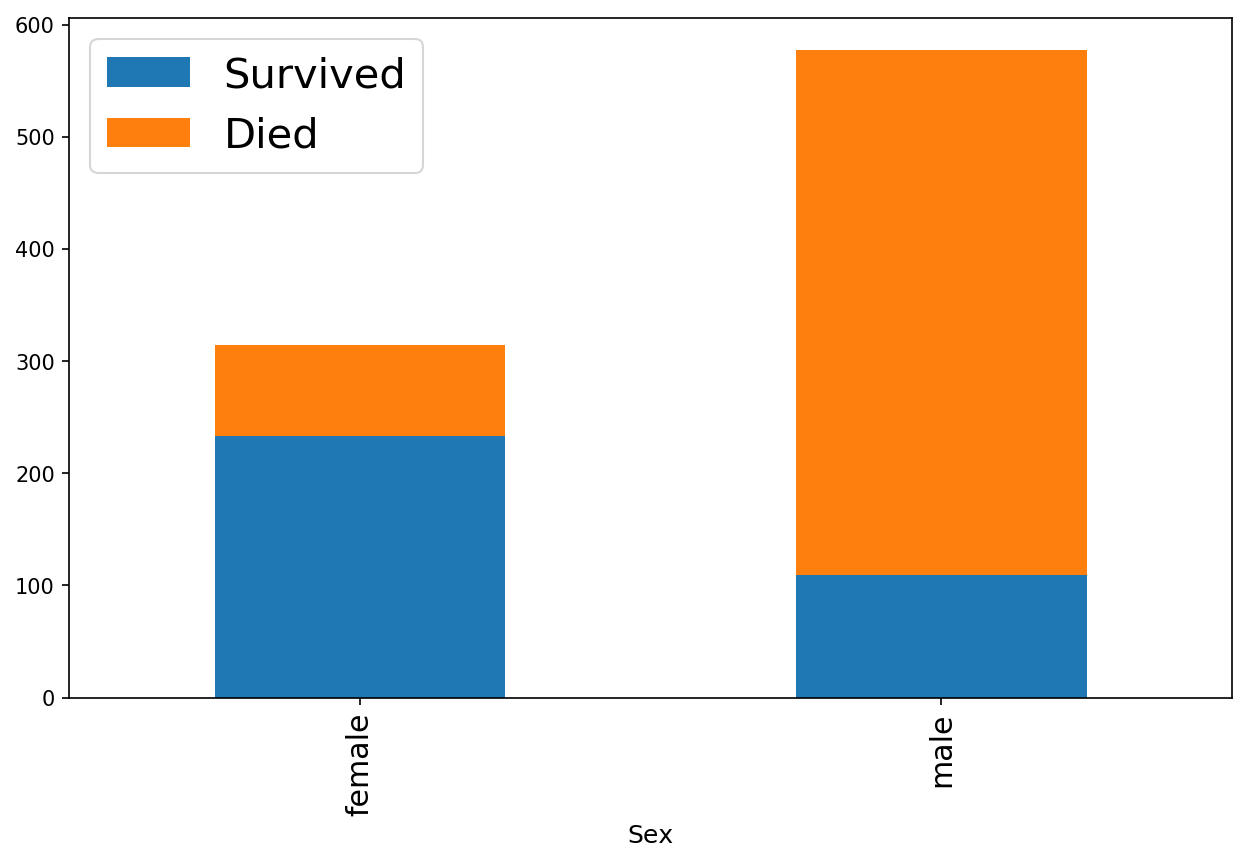

In [124]:
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

From the above graph it is evident that male 
passengers are died.


Let's correlate the age with the survival variable.

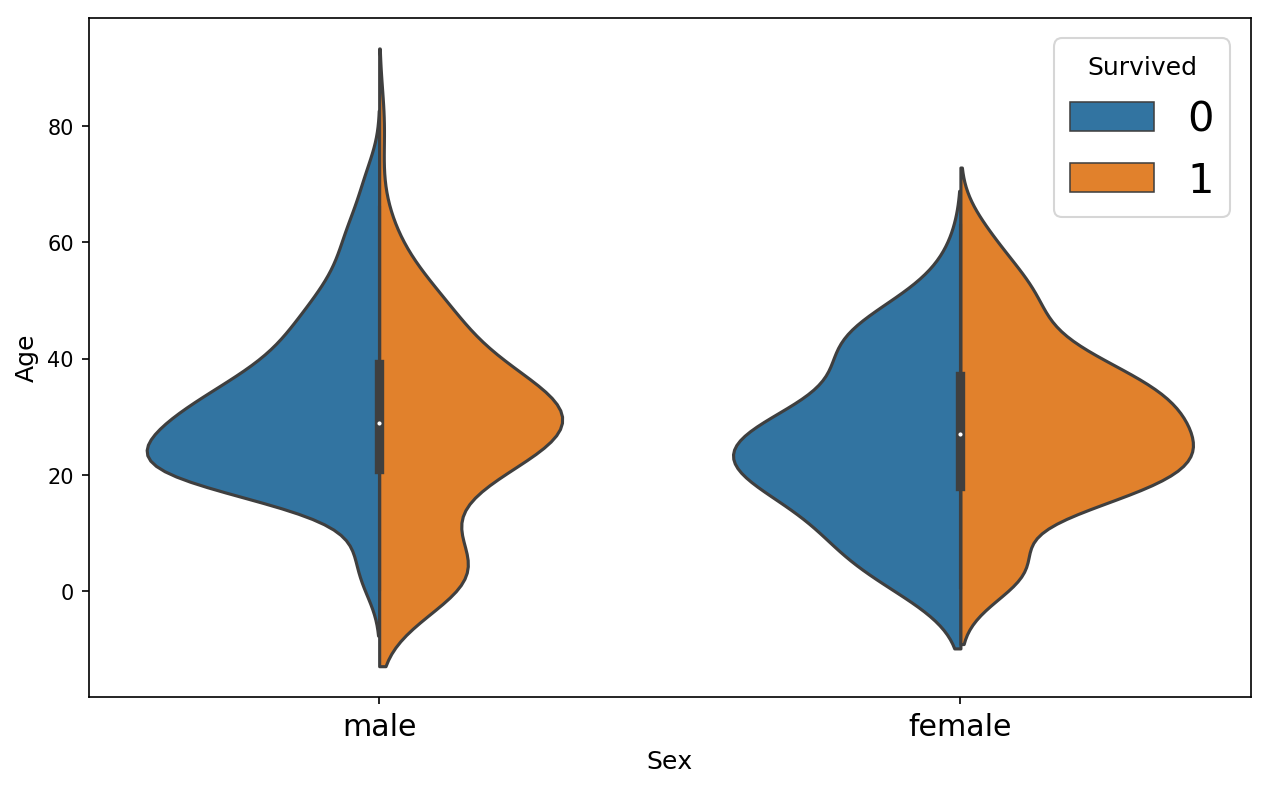

In [125]:
sns.violinplot(x='Sex', y='Age', hue='Survived',data=data,split=True)

As we can see in the chart above, Women survive more than men, as decpicted bhy larger 
female green histogram.

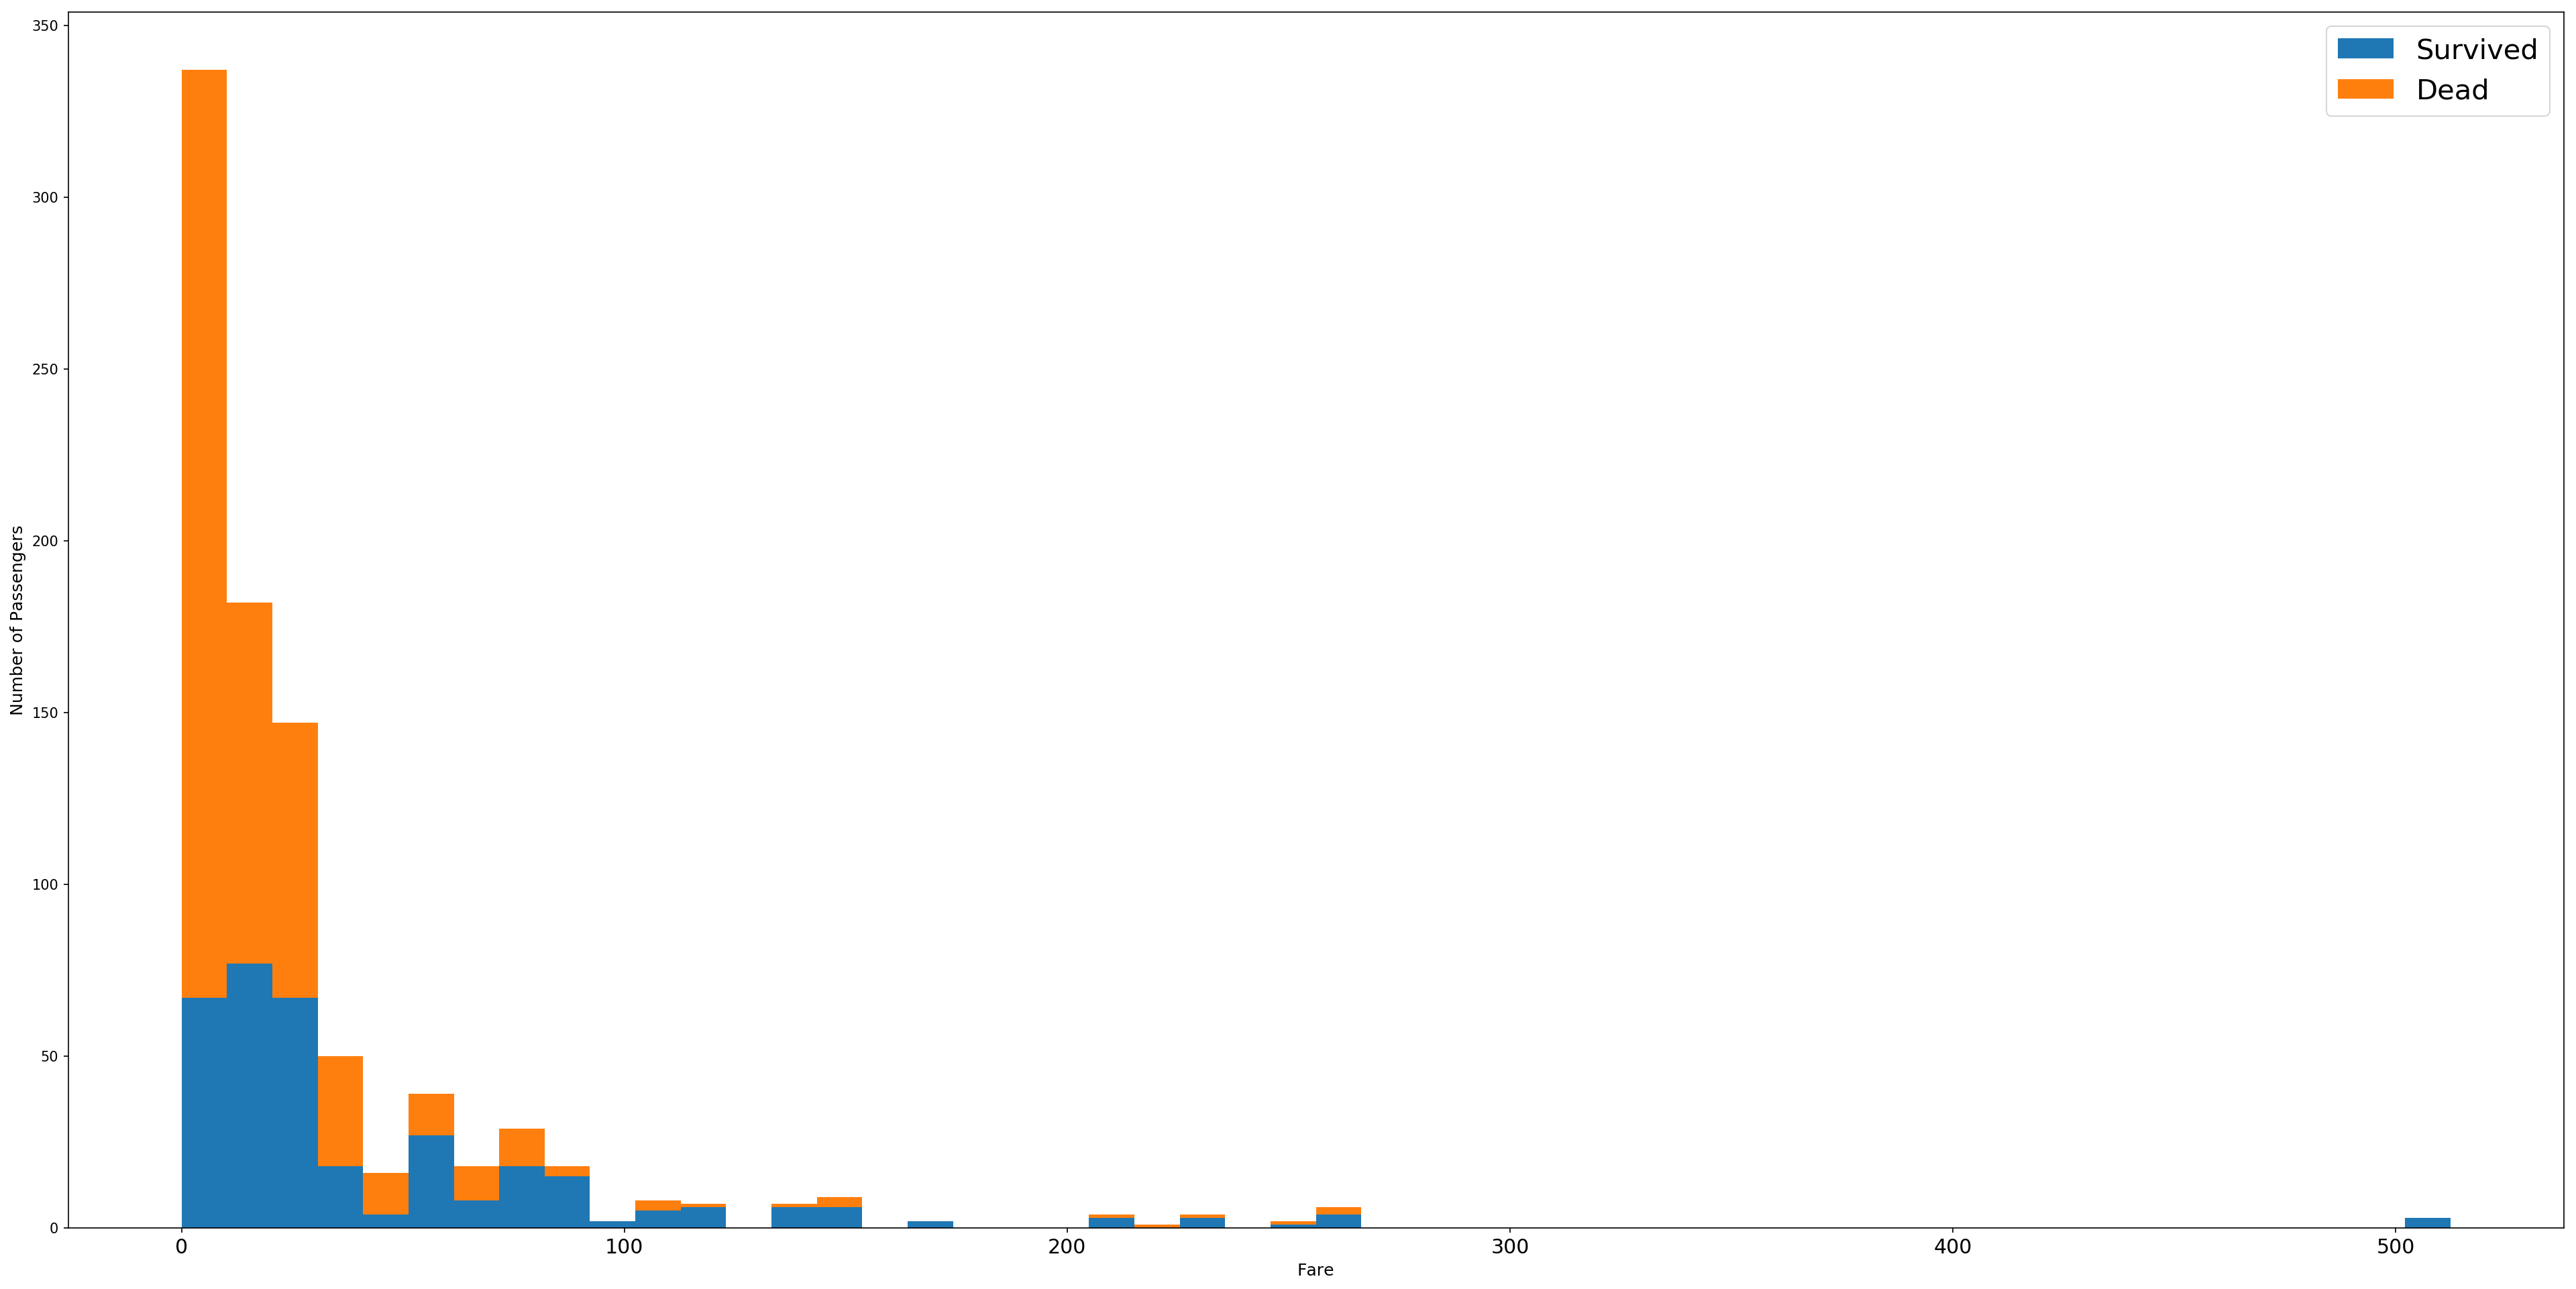

In [127]:
#Check the Fare ticket of each passagener and see how it impact the survival.

figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

Above graph says passengers with cheaper ticket fares are more likely to die.

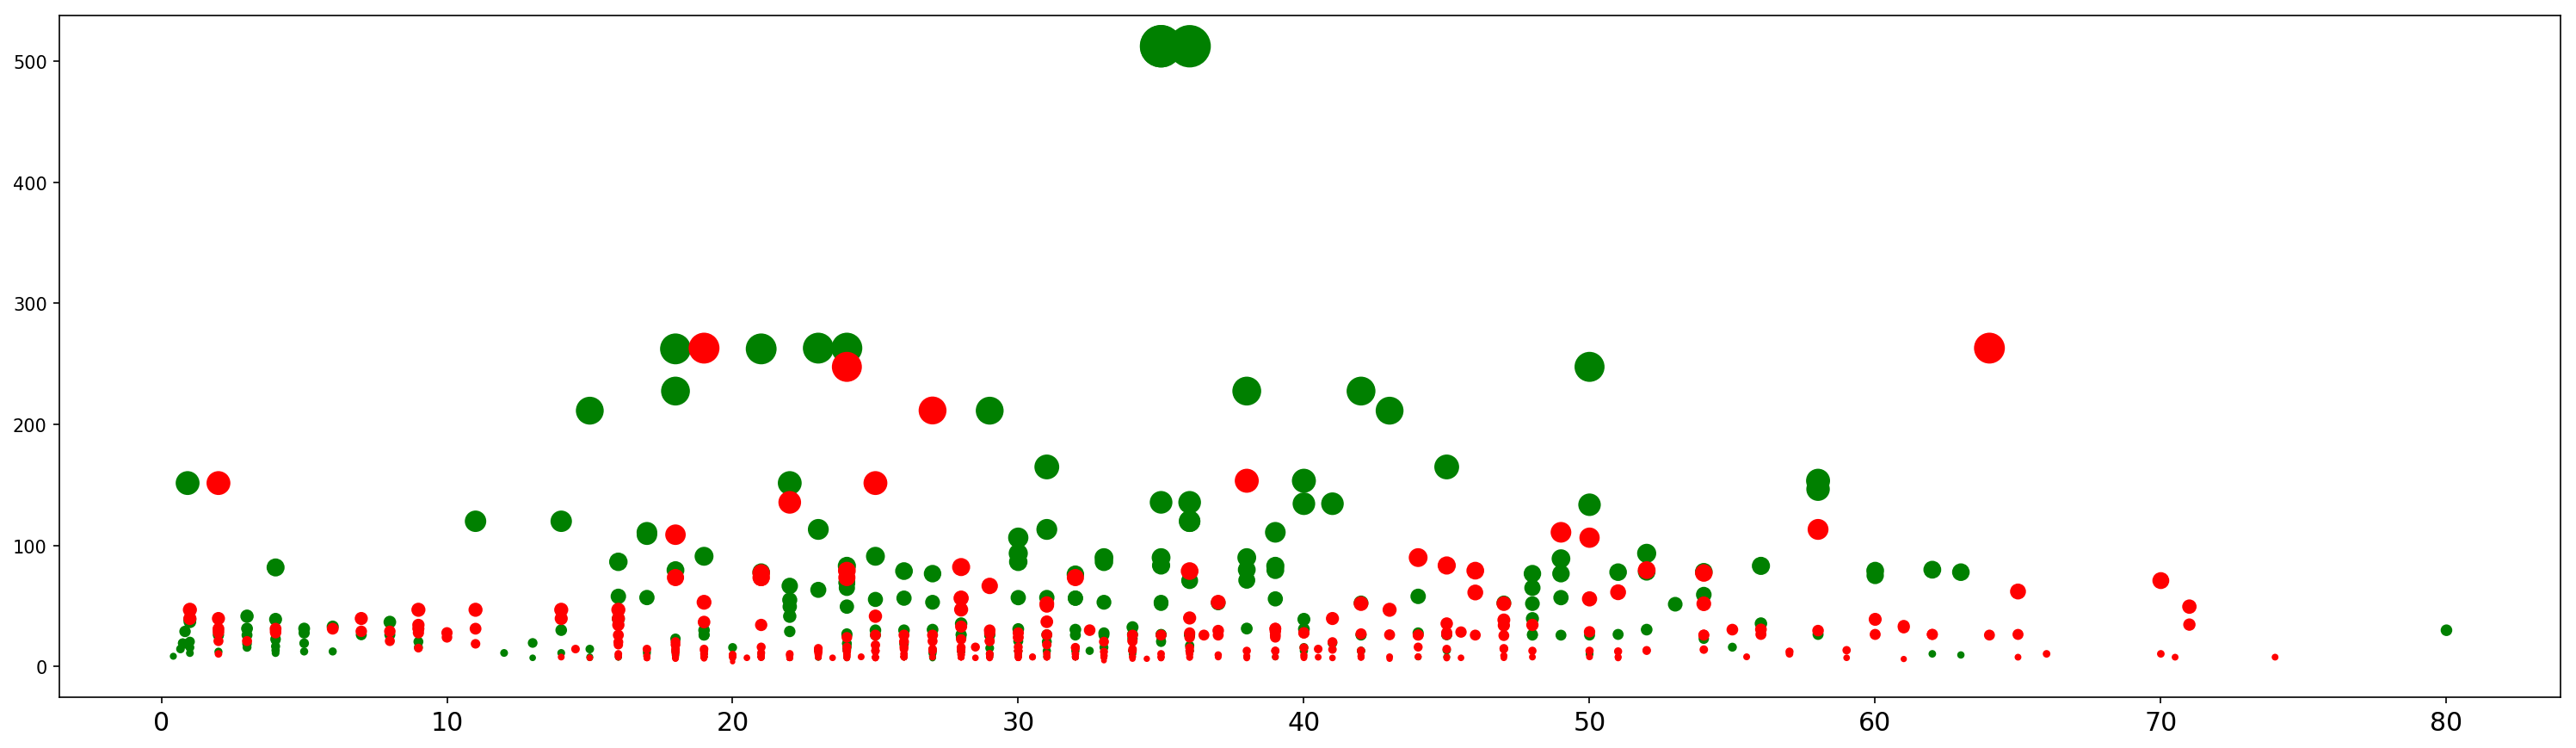

In [128]:
#combining age, fare and survival in one chart.

plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

Size of the circles is proportional to the ticket fare.
X-axis = AGE
Y-axis = Ticket_Fare
Green = Survived
Red = Died

Small green dots between x=0 & x=7 : Children who were saved
Small red dots between x=10 & x=45 : adults who died and from a lower classes
Large green dots between x=20 & x=45 : Adults with larger ticket fares who are sruvived


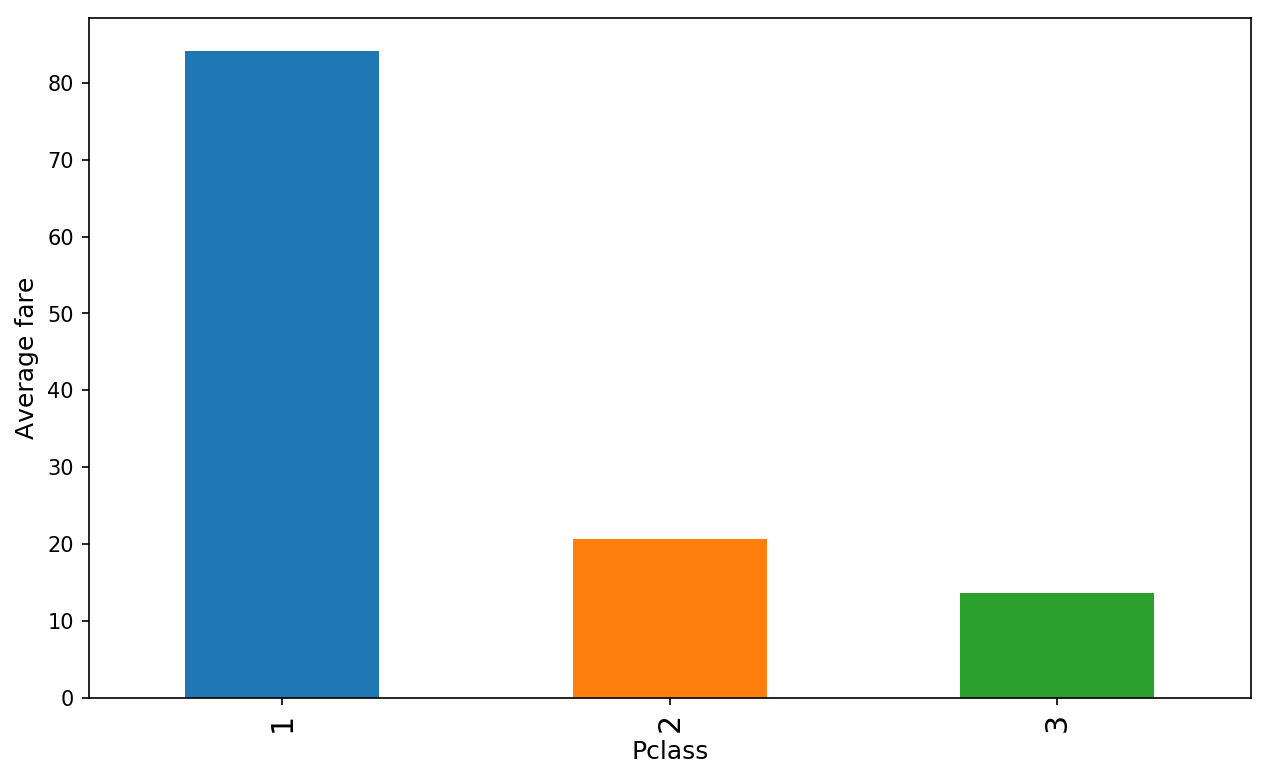

In [130]:
#ticket fare versues class

ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',ax=ax)

# Feature Engineering

In [142]:
#Combining the test and train data to prepare the data for modeling.

x_train = train_raw.drop(['Survived'],1)
y_train = train_raw['Survived']
x_test = test_raw

In [143]:
df_combined = x_train.append(x_test)
df_combined.shape

(1309, 11)

In [144]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [145]:
display_all(df_combined.tail().T)

,413,414,415,416,417
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Sex,male,female,male,male,male
Age,NaN,39,38.5,NaN,NaN
SibSp,0,0,0,0,1
Parch,0,0,0,0,1
Ticket,A.5. 3236,PC 17758,SOTON/O.Q. 3101262,359309,2668
Fare,8.05,108.9,7.25,8.05,22.3583
Cabin,NaN,C105,NaN,NaN,NaN


In [146]:
#train_cats module from fastai, which changes the strings in a dataframe to a 
#categorical values

train_cats(df_combined)

In [147]:
#Check the missing data %
display_all(df_combined.isnull().sum().sort_index()/len(df_combined))

Age            0.200917
Cabin          0.774637
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

In [148]:
#proc_df takes a data frame df and splits off the response variable, and
#changes the df into an entirely numeric dataframe. In this case am excluding the 
# fields in ignore_flds as they need further processing.

df,y,nas = proc_df(df_combined,y_fld=None,ignore_flds=['Age','Name','Embarked','Cabin','Parch',
                                                      'SibSp'])
df.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,1,3,2,721,7.2500,False
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,2,1,1,817,71.2833,False
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,3,3,1,915,7.9250,False
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,4,1,1,66,53.1000,False
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,5,3,2,650,8.0500,False


### Process Family

In [149]:
def process_family():
    
    global df
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

In [150]:
df = process_family()

### Process Embarked

In [151]:
def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    df.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [152]:
df = process_embarked()

### Process Cabin

In [153]:
def process_cabin():
    global df    
    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
#     status('cabin')
    return df

In [154]:
df = process_cabin()

### Get Title from Name

In [155]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [156]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
#     status('Title')
    return df

In [157]:
df = get_titles()
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,...,1,0,0,0,0,0,0,0,1,Mr


### Process Age

In [158]:
#summarize the Age grouped by sex, class and title
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [159]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,1,1,Miss,30.0
1,1,1,Mrs,45.0
2,1,1,Officer,49.0
3,1,1,Royalty,40.5
4,1,2,Miss,20.0


In [160]:
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,...,1,0,0,0,0,0,0,0,1,Mr


In [161]:
#Assing the value of age for missing values based on the group.
#If a title is miising then the age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#     status('age')
    return df

In [162]:
df = process_age()

In [163]:
#Check for missing values.

display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000000
Fare_na        0.000000
LargeFamily    0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamily    0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

In [164]:
df[df.Title.isnull()]

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
414,39.0,"Oliva y Ocana, Dona. Fermina",0,0,1306,1,1,835,108.9,False,...,0,0,0,1,0,0,0,0,0,NaN


### Process Name

In [165]:
def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
#     status('names')
    return df

In [166]:
df = process_names()

In [167]:
df.head()

,Age,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,1,1,3,2,721,7.2500,False,2,...,0,0,0,1,0,0,1,0,0,0
1,38.0,0,1,2,1,1,817,71.2833,False,2,...,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,3,3,1,915,7.9250,False,1,...,0,0,0,1,0,1,0,0,0,0
3,35.0,0,1,4,1,1,66,53.1000,False,2,...,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,5,3,2,650,8.0500,False,1,...,0,0,0,1,0,0,1,0,0,0


In [168]:
#Now no null vlaues
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
Fare_na          0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

## Build and trian the Model

In [169]:
#Seperate out the train & test data

x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape

((891, 30), (418, 30))

In [170]:
#split the tarin data into train and valid set
def split_vals(a,n): return a[:n], a[n:]
valid_count =60
n_trn = len(x_train)-valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)

In [171]:
x_train1.shape,y_train1.shape,x_valid1.shape,y_valid1.shape

((831, 30), (831,), (60, 30), (60,))

In [172]:
m = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train1,y_train1)
m.score(x_train1,y_train1)

0.9338146811070999

### Model Evaluation

In [173]:
y_predict=m.predict(x_valid1)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid1,y_predict)

0.8666666666666667

In [174]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1,y_predict))

             precision    recall  f1-score   support

          0       0.89      0.89      0.89        38
          1       0.82      0.82      0.82        22

avg / total       0.87      0.87      0.87        60



In [175]:
#confusion Matrix
print(confusion_matrix(y_valid1,y_predict))

[[34  4]
 [ 4 18]]


In [176]:
#Feature importance
fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
26,Title_Mr,0.188297
5,Sex,0.165645
6,Ticket,0.117353
7,Fare,0.093596
3,PassengerId,0.087954
0,Age,0.086400
4,Pclass,0.062095
9,FamilySize,0.031148
12,LargeFamily,0.024746
23,Cabin_T,0.024503


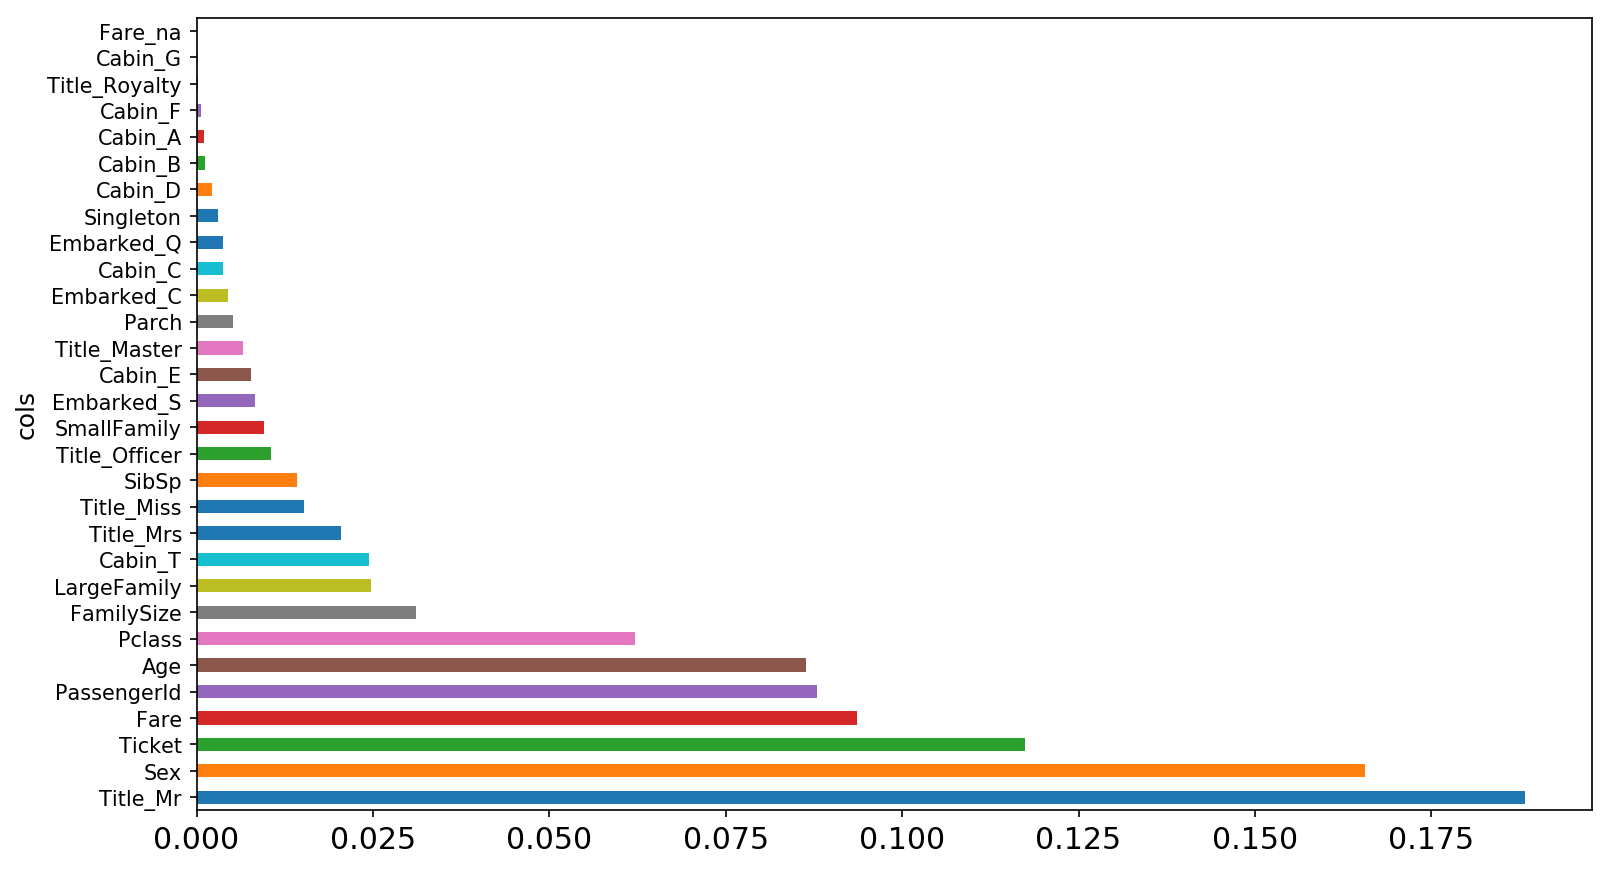

In [177]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [92]:
# Keeping only the variables which are significant for the model(>0.01)
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

24         Title_Mr
4               Sex
5            Ticket
6              Fare
2       PassengerId
0               Age
3            Pclass
8        FamilySize
21          Cabin_T
11      LargeFamily
23       Title_Miss
1             SibSp
26    Title_Officer
Name: cols, dtype: object

# Our final model!

In [95]:
#Now training the model on the entire data with only the important features.
x_train = x_train[to_keep]
x_train

In [96]:
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train,y_train)
m.score(x_train,y_train)

0.9382716049382716

####  We could notice that the score has increased after removing some featurs and training on the complete data.

### Run the model on the test data

In [85]:
x_test = x_test[to_keep]
output=m.predict(x_test).astype(int)

In [86]:
output.size

418

### Save the output predictions in the requried format and submit it to Kaggle!!

In [520]:
aux=pd.read_csv(f'{PATH}test.csv',low_memory=False)
df_output = pd.DataFrame()
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv(f'{PATH}titanic_fastai2.csv', index=False)

### On the Kaggle leaderborad this model achieved a score of 0.81339 ( Reached top 7%).